In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from meteo_imp.kalman.fastai import *
from meteo_imp.kalman.filter import *
from meteo_imp.utils import *
from meteo_imp.data import *

from fastai.tabular.learner import *
from fastai.learner import *
from fastai.callback.all import *
import pandas as pd
import numpy as np
import torch

In [ ]:
@cache_disk(cache_dir / "full_hai")
def load_data(dtype=np.float32):
    return read_fluxnet_csv(hai_path, None, num_dtype=dtype)

hai64 = load_data(np.float64)

In [ ]:
model = KalmanFilter.init_random(n_dim_state = hai64.shape[1], n_dim_obs=hai64.shape[1], dtype=torch.float64).cuda()

In [ ]:
model.use_smooth = False

In [ ]:
dls = make_dataloader(hai64[:5*20_000], block_len=200, gap_len=0, bs=100) # about 5 year of data 

In [ ]:
dls.one_batch()[0][0].dtype, dls.one_batch()[0][0].device

(torch.float64, device(type='cuda', index=0))

In [ ]:
learn = Learner(dls, model, loss_func=KalmanLoss(only_gap=False), cbs=[Float64Callback])

In [ ]:
learn.fit(20, 3e-2)

epoch,train_loss,valid_loss,time
0,-225053.584652,-224369.655319,00:15
1,-226378.066569,-226848.424885,00:15
2,-227703.669727,-229206.169680,00:15
3,-229028.077627,-231511.072567,00:15
4,-230353.775751,-233714.150492,00:16
5,-231678.219841,-235869.030137,00:16
6,-233004.201092,-237945.050335,00:16
7,-234329.448052,-239972.437530,00:16
8,-235656.336272,-241947.550967,00:17
9,-236984.012229,-243874.865120,00:17


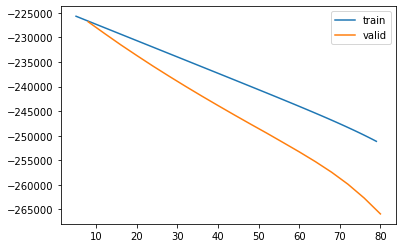

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# learn.fit(10, 1e-2)

In [ ]:
# learn.recorder.plot_loss()

In [ ]:
trained_state = learn.model.state_dict()

In [ ]:
display_as_row(learn.model.get_info())

In [ ]:
dls.fs[0][-1]

NormalizeMasked -- {'mean': tensor([  8.4696, 122.5591,   3.3335], dtype=torch.float64), 'std': tensor([  7.8949, 204.6408,   4.4542], dtype=torch.float64)}:
encodes: (MaskedTensor,object) -> encodes
(object,object) -> encodes
decodes: (NormalsParams,object) -> decodes

In [ ]:
# torch.save(learn.model, "trained_filter_29_dec_1.pickle")

## Results

In [ ]:
from meteo_imp.data_preparation import MeteoDataTest
from meteo_imp.kalman.imputation import KalmanImputation

In [ ]:
def gap2res(var_sel, gap_len, gap_start, block_start=1000, block_end=1200):
    data = MeteoDataTest(hai64.iloc[block_start:block_end, :]).add_gap(gap_len, var_sel, gap_start)
    imp = KalmanImputation(data.data)
    print(imp.scaler.x_mean, imp.scaler.x_std)
    imp.model.filter = learn.model.cpu()
    return imp.to_result(data.data_compl_tidy, var_names= data.data.columns, units=units, pred_all=True)

In [ ]:
data = MeteoDataTest(hai64)

In [ ]:
var_sel = data.data.columns
imp = KalmanImputation(data.data)

In [ ]:
imp.scaler.x_std

tensor([  7.9246, 204.0026,   4.3684], dtype=torch.float64)

In [ ]:
imp.model.filter.trans_cov.dtype

torch.float32

In [ ]:
%time gap2res(var_sel, 10, 10)

tensor([-5.9442, 37.5272,  0.3039], dtype=torch.float64) tensor([ 3.5376, 74.6820,  0.4623], dtype=torch.float64)


IndexError: The shape of the mask [1] at index 0 does not match the shape of the indexed tensor [200, 3, 1] at index 0

In [ ]:
gaps = [2, 5, 7, 10, 20, 30, 50, 100]
gap_starts = [0, 30, 60, 90]

In [ ]:
from ipywidgets import interact_manual, IntSlider

In [ ]:
#| include: false
@interact_manual(TA=True,
                 SW_IN=True,
                 VPD=True,
                 gap_len=IntSlider(10, 1,100),
                 gap_start=IntSlider(30, 1,100),
                 block_start = IntSlider(1000, 0, 20_000, 1000),
                 block_len = IntSlider(200, 10, 1000, 10)
        )
def show_diff_gaps_res(TA, SW_IN, VPD, gap_len, gap_start, block_start, block_len):
    var_sel = []
    if TA: var_sel.append('TA')
    if SW_IN: var_sel.append('SW_IN')
    if VPD: var_sel.append('VPD')
    var_sel = (*var_sel,)
    gap2res(var_sel, gap_len, gap_start, block_start, block_start + block_len).display_results()
    

interactive(children=(Checkbox(value=True, description='TA'), Checkbox(value=True, description='SW_IN'), Check…